# VAE with convolutional layers for CIFAR10

Inspired by homework 3

# Import

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.cluster import normalized_mutual_info_score

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=[20, 10])
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    out, _, _ = model(x) 
    x_concat = torch.cat([x, out], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)

def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, 64).to(device) # n = batch of imgs
        out = model.decode(z).view(-1, 3, 32, 32)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

def plot_conditional_generation(model, n=8, fix_number=None):
    with torch.no_grad():
        matrix = np.zeros((n,n_classes))
        matrix[:,0] = 1

        if fix_number is None:
            final = matrix[:]
            for i in range(1,n_classes):
                final = np.vstack((final,np.roll(matrix,i)))
            #z = torch.randn(8*n_classes, z_dim).to(device)
            z = torch.randn(8, z_dim)
            z = z.repeat(n_classes,1).to(device)
            y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
            out = model.decode(z,y_onehot).view(-1, 3, 32, 32)
        else:
            z = torch.randn(n, z_dim).to(device)
            y_onehot = torch.tensor(np.roll(matrix, fix_number)).type(torch.FloatTensor).to(device)
            out = model.decode(z,y_onehot).view(-1, 3, 32, 32)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

cuda


# Dataset

In [ ]:
data_dir = 'data'
# CIFAR10 dataset
dataset = torchvision.datasets.CIFAR10(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=128, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
image = next(iter(data_loader))
image[0].shape

torch.Size([128, 3, 32, 32])

# Sandbox

In [ ]:
modules = []
in_channels = 3
for h_dim in [16, 32, 32, 64]:
    modules.append(
        nn.Sequential(
            nn.Conv2d(in_channels, out_channels=h_dim,
                      kernel_size= 3, stride= 2, padding  = 1),
            nn.BatchNorm2d(h_dim),
            nn.LeakyReLU())
    )
    in_channels = h_dim
my_encoder = nn.Sequential(*modules)

In [ ]:
x = next(iter(data_loader))

In [ ]:
x[0].shape

torch.Size([128, 3, 32, 32])

In [ ]:
my_encoder(x[0]).shape

torch.Size([128, 64, 2, 2])

In [ ]:
torch.ones(5).zero_()

tensor([0., 0., 0., 0., 0.])

# CNN VAE

In [ ]:
# Hyper-parameters
image_size = 3*32*32
h_dim = 400
z_dim = 64
learning_rate = 1e-3

# VAE model
class VAE(nn.Module):
    def __init__(self, img_size = 32, in_channels = 3, hidden_dims=[32, 64], latent_dim = 64):
        super(VAE, self).__init__()
        hidden_dims_copy = hidden_dims.copy()
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        self.img_size = img_size
        self.embedding_img_size = self.img_size//(2**len(self.hidden_dims))
        # Init Encoder
        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim
        self.encoder = nn.Sequential(*modules)

        self.fc_mu = nn.Linear(hidden_dims[-1]*self.embedding_img_size*self.embedding_img_size, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*self.embedding_img_size*self.embedding_img_size, latent_dim)

        # Init decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*self.embedding_img_size*self.embedding_img_size)
        hidden_dims_copy.reverse()
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims_copy[i],
                                       hidden_dims_copy[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims_copy[i + 1]),
                    nn.LeakyReLU())
            )
        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims_copy[-1],
                                               hidden_dims_copy[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims_copy[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims_copy[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())
        
    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, self.hidden_dims[-1], self.embedding_img_size, self.embedding_img_size) # B x C x H x W
        result = self.decoder(result)
        result = self.final_layer(result)
        return result
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE(hidden_dims=[32, 64, 64, 128, 128], latent_dim = 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training

In [ ]:
num_epochs = 3

# Start training
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(data_loader):
        # Forward pass
        # x = x.to(device).view(-1, image_size)
        x = x.to(device)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.mse_loss(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))

Epoch[1/3], Step [10/391], Reconst Loss: 65.1703, KL Div: 15.4599
Epoch[1/3], Step [20/391], Reconst Loss: 67.8788, KL Div: 15.3917
Epoch[1/3], Step [30/391], Reconst Loss: 68.7853, KL Div: 15.5797
Epoch[1/3], Step [40/391], Reconst Loss: 69.0288, KL Div: 15.4854
Epoch[1/3], Step [50/391], Reconst Loss: 64.5813, KL Div: 15.4127
Epoch[1/3], Step [60/391], Reconst Loss: 68.7827, KL Div: 15.6780
Epoch[1/3], Step [70/391], Reconst Loss: 67.7585, KL Div: 16.0042
Epoch[1/3], Step [80/391], Reconst Loss: 67.6788, KL Div: 15.3358
Epoch[1/3], Step [90/391], Reconst Loss: 70.3111, KL Div: 15.3693
Epoch[1/3], Step [100/391], Reconst Loss: 63.1756, KL Div: 15.4777
Epoch[1/3], Step [110/391], Reconst Loss: 73.3297, KL Div: 15.7498
Epoch[1/3], Step [120/391], Reconst Loss: 67.6406, KL Div: 15.5356
Epoch[1/3], Step [130/391], Reconst Loss: 69.5057, KL Div: 15.7906
Epoch[1/3], Step [140/391], Reconst Loss: 69.4381, KL Div: 15.5751
Epoch[1/3], Step [150/391], Reconst Loss: 67.1566, KL Div: 15.3611
Epoc

# Results (latent_dim = 64)

6 epochs hidden_dims=[32, 64, 64, 128, 128]

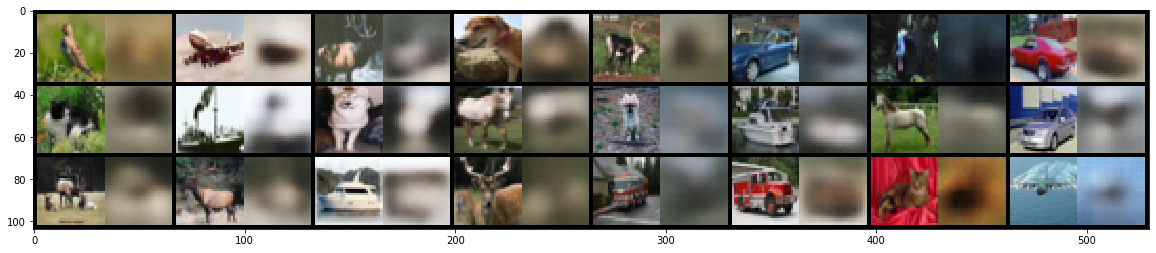

In [ ]:
plot_reconstruction(model)

6 epochs hidden_dims=[32, 32, 64, 128]

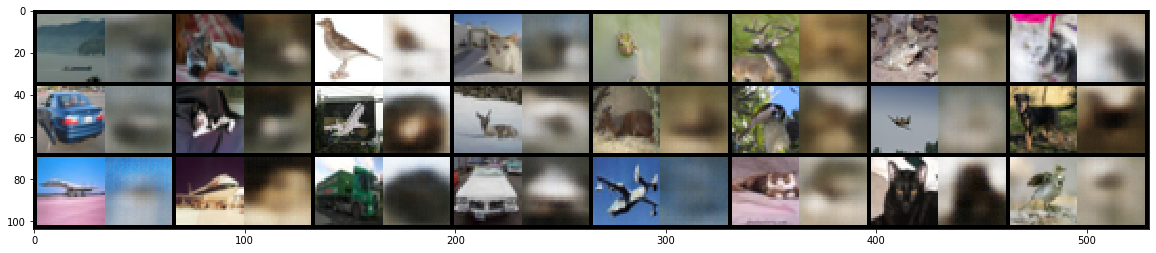

In [ ]:
plot_reconstruction(model)

9 epochs [16, 32, 32, 64]

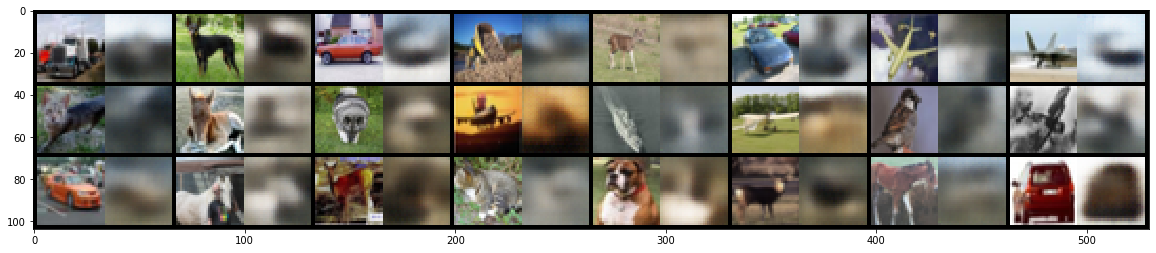

In [ ]:
plot_reconstruction(model)

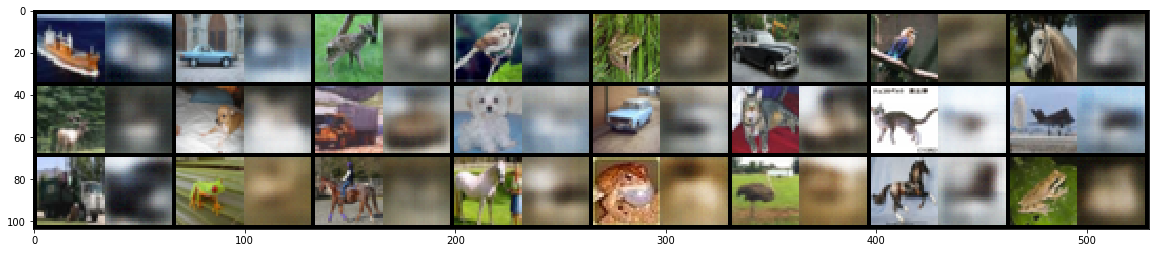

In [ ]:
plot_reconstruction(model)

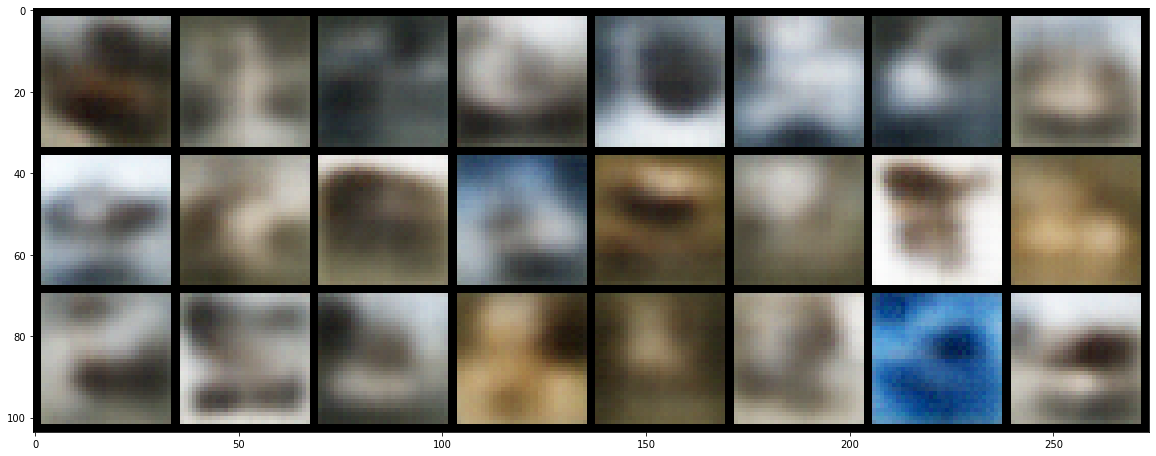

In [ ]:
plot_generation(model)

6 epochs hidden_dims = [32, 64]

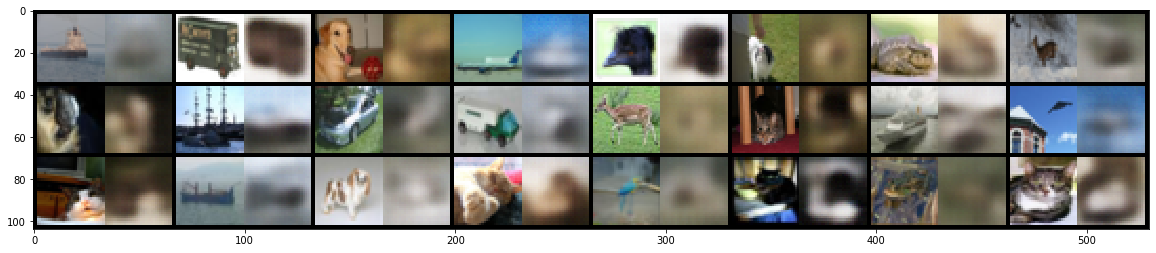

In [ ]:
plot_reconstruction(model)

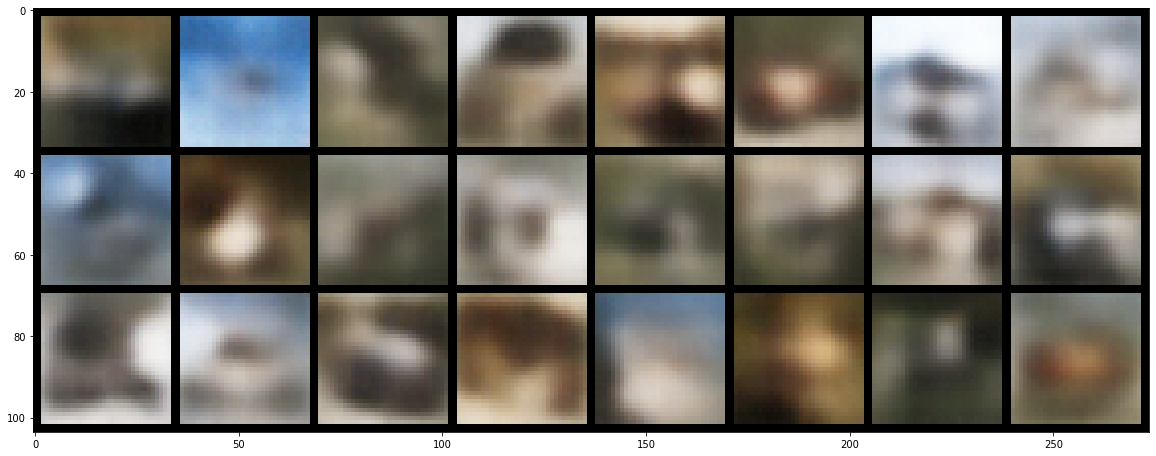

In [ ]:
plot_generation(model)